In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import tensorflow as tf
np.random.seed(seed=0)

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [3]:
!rm ./books-autoencoder/.DS_STORE
books_path = "./books-autoencoder/"
new_path = "../"
books_list = sorted(os.listdir(books_path))

documents = list()

for i in books_list:
    f = open(books_path + i, 'r')
    doc = list(map(lambda x: x.replace("\n", ""), f.readlines()))
    doc = [x.replace("</s>", " </s>")[:-5] for x in doc]
    documents.append(doc)


    f.close()

rm: ./books-autoencoder/.DS_STORE: No such file or directory


In [4]:
# 전체 세그먼트 포함하는 리스트
doc_total = list()
for doc in documents:
    doc_total.extend(doc)

In [5]:
text_len = [len(s.split()) for s in doc_total]
seg_len = [len(s) for s in documents]

In [6]:
np.min(text_len)

3

In [7]:
np.max(seg_len)

98

텍스트의 최소 길이 : 3
텍스트의 최대 길이 : 2686
텍스트의 평균 길이 : 83.44231867504283


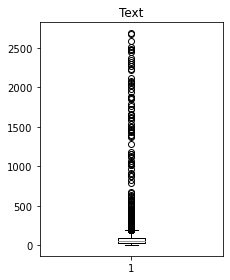

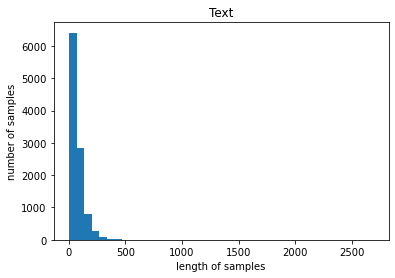

In [8]:
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
text_max_len = 150

텍스트의 최소 길이 : 29
텍스트의 최대 길이 : 98
텍스트의 평균 길이 : 77.82222222222222


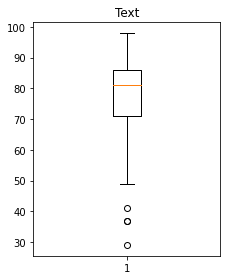

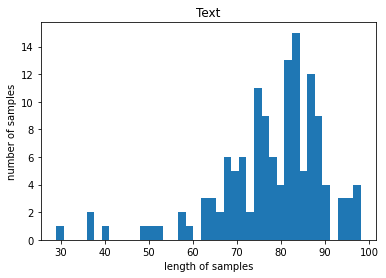

In [10]:
print('텍스트의 최소 길이 : {}'.format(np.min(seg_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(seg_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(seg_len)))

plt.subplot(1,2,1)
plt.boxplot(seg_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(seg_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
seg_max_len = 98

In [12]:
encoder_input = documents

In [13]:
decoder_input = list()
for doc in encoder_input:
    tmp = list()
    for x in doc:
        x = 'sostoken ' + x
        tmp.append(x)
    decoder_input.append(tmp)
    
decoder_target = list()
for doc in encoder_input:
    tmp = list()
    for x in doc:
        x = x + ' eostoken'
        tmp.append(x)
    decoder_target.append(tmp)

In [14]:
encoder_input = np.array(encoder_input)
decoder_input = np.array(decoder_input)
decoder_target = np.array(decoder_target)

<ipython-input-14-9c07af7f6dda>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  encoder_input = np.array(encoder_input)
<ipython-input-14-9c07af7f6dda>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  decoder_input = np.array(decoder_input)
<ipython-input-14-9c07af7f6dda>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  decoder_target

In [15]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

[120  33  45 126  83   8  52 104  22 113  48  97  24  76  43  90  54  68
 131  92   7  26  95  10  62 100  16   2  51  63  85  50  30 114  71  61
  56 112 129  13  44 118  59  84  15  60  40 106 132   3 105 111   6 101
 107 109  73 123  78  66  96 108  27  18 133  11  86  91  41  93   1  89
 122  42   4  17  38   5  53 128 115   0  34  28  55  75  35  23  74  31
  94  57 110 121  32 119  14  98  19  29  49 116  99  82  64 134  79  69
  80  20 130  72  77  25  37  81 124  46 127  39 102  65  58  12 125  88
  70  87  36  21   9 103  67 117  47]


In [16]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 27


In [17]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [18]:
print(len(encoder_input_train))
print(len(decoder_input_train))
print(len(decoder_target_train))

108
108
108


In [19]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 108
훈련 레이블의 개수 : 108
테스트 데이터의 개수 : 27
테스트 레이블의 개수 : 27


In [20]:
encoder_total = list()
for doc in encoder_input_train:
    encoder_total.extend(doc)

In [21]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_total)

In [22]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 147221
등장 빈도가 6번 이하인 희귀 단어의 수: 134637
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 12584
단어 집합에서 희귀 단어의 비율: 91.45230639650593
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 27.597405624875947


In [23]:
src_vocab = 130000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_total)

In [24]:
embeded_encoder_input_train = list()
for doc in encoder_input_train:
    doc = src_tokenizer.texts_to_sequences(doc)
    embeded_encoder_input_train.append(doc)
encoder_input_train = embeded_encoder_input_train

embeded_encoder_input_test = list()
for doc in encoder_input_test:
    doc = src_tokenizer.texts_to_sequences(doc)
    embeded_encoder_input_test.append(doc)
encoder_input_test = embeded_encoder_input_test

In [25]:
decoder_total = list()
for doc in decoder_input_train:
    decoder_total.extend(doc)
for doc in decoder_target_train:
    decoder_total.extend(doc)

In [26]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_total)

In [27]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 147223
등장 빈도가 5번 이하인 희귀 단어의 수: 116539
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 30684
단어 집합에서 희귀 단어의 비율: 79.15814784374724
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 17.842370657631974


In [28]:
tar_vocab = 110000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_total)

In [29]:
embeded_decoder_input_train = list()
for doc in decoder_input_train:
    doc = tar_tokenizer.texts_to_sequences(doc)
    embeded_decoder_input_train.append(doc)
decoder_input_train = embeded_decoder_input_train

embeded_decoder_input_test = list()
for doc in decoder_input_test:
    doc = tar_tokenizer.texts_to_sequences(doc)
    embeded_decoder_input_test.append(doc)
decoder_input_test = embeded_decoder_input_test

embeded_decoder_target_train = list()
for doc in decoder_target_train:
    doc = tar_tokenizer.texts_to_sequences(doc)
    embeded_decoder_target_train.append(doc)
decoder_target_train = embeded_decoder_target_train

embeded_decoder_target_test = list()
for doc in decoder_target_test:
    doc = tar_tokenizer.texts_to_sequences(doc)
    embeded_decoder_target_test.append(doc)
decoder_target_test = embeded_decoder_target_test

In [30]:
drop_train = [index for index, sentence in enumerate(doc) for doc in decoder_input_train if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(doc) for doc in decoder_input_test if len(sentence) == 1]

In [31]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 108
훈련 레이블의 개수 : 108
테스트 데이터의 개수 : 27
테스트 레이블의 개수 : 27


/Users/hbae/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [32]:
padded_sent_encoder_input_train = list()
for doc in encoder_input_train:
    doc = pad_sequences(doc, maxlen = text_max_len, padding='post')
    padded_sent_encoder_input_train.append(doc)
encoder_input_train = padded_sent_encoder_input_train

padded_sent_encoder_input_test = list()
for doc in encoder_input_test:
    doc = pad_sequences(doc, maxlen = text_max_len, padding='post')
    padded_sent_encoder_input_test.append(doc)
encoder_input_test = padded_sent_encoder_input_test

padded_sent_decoder_input_train = list()
for doc in decoder_input_train:
    doc = pad_sequences(doc, maxlen = text_max_len, padding='post')
    padded_sent_decoder_input_train.append(doc)
decoder_input_train = padded_sent_decoder_input_train

padded_sent_decoder_target_train = list()
for doc in decoder_target_train:
    doc = pad_sequences(doc, maxlen = text_max_len, padding='post')
    padded_sent_decoder_target_train.append(doc)
decoder_target_train = padded_sent_decoder_target_train

padded_sent_decoder_input_test = list()
for doc in decoder_input_test:
    doc = pad_sequences(doc, maxlen = text_max_len, padding='post')
    padded_sent_decoder_input_test.append(doc)
decoder_input_test = padded_sent_decoder_input_test

padded_sent_decoder_target_test = list()
for doc in decoder_target_test:
    doc = pad_sequences(doc, maxlen = text_max_len, padding='post')
    padded_sent_decoder_target_test.append(doc)
decoder_target_test = padded_sent_decoder_target_test

In [33]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = seg_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = seg_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = seg_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = seg_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = seg_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = seg_max_len, padding='post')

# 최대 segment 개수만큼 input 리스트 만들기(일단 4개로 함)

In [34]:
encoder_input_train1 = list()
encoder_input_train2 = list()
encoder_input_train3 = list()
encoder_input_train4 = list()

for i, book in enumerate(encoder_input_train):
    encoder_input_train1.append(encoder_input_train[i][0]) # i번째 책의 첫번째 문장
    encoder_input_train2.append(encoder_input_train[i][1]) # i번째 책의 두번째 문장
    encoder_input_train3.append(encoder_input_train[i][2]) # i번째 책의 세번째 문장
    encoder_input_train4.append(encoder_input_train[i][3]) # i번째 책의 네번째 문장
    
encoder_input_train1 = np.array(encoder_input_train1)
encoder_input_train2 = np.array(encoder_input_train2)
encoder_input_train3 = np.array(encoder_input_train3)
encoder_input_train4 = np.array(encoder_input_train4)

In [35]:
encoder_input_test1 = list()
encoder_input_test2 = list()
encoder_input_test3 = list()
encoder_input_test4 = list()

for i, book in enumerate(encoder_input_test):
    encoder_input_test1.append(encoder_input_test[i][0]) # i번째 책의 첫번째 문장
    encoder_input_test2.append(encoder_input_test[i][1]) # i번째 책의 두번째 문장
    encoder_input_test3.append(encoder_input_test[i][2]) # i번째 책의 세번째 문장
    encoder_input_test4.append(encoder_input_test[i][3]) # i번째 책의 네번째 문장
    
encoder_input_test1 = np.array(encoder_input_test1)
encoder_input_test2 = np.array(encoder_input_test2)
encoder_input_test3 = np.array(encoder_input_test3)
encoder_input_test4 = np.array(encoder_input_test4)

In [36]:
decoder_input_train1 = list()
decoder_input_train2 = list()
decoder_input_train3 = list()
decoder_input_train4 = list()

for i, book in enumerate(decoder_input_train):
    decoder_input_train1.append(decoder_input_train[i][0]) # i번째 책의 첫번째 문장
    decoder_input_train2.append(decoder_input_train[i][1]) # i번째 책의 두번째 문장
    decoder_input_train3.append(decoder_input_train[i][2]) # i번째 책의 세번째 문장
    decoder_input_train4.append(decoder_input_train[i][3]) # i번째 책의 네번째 문장
    
decoder_input_train1 = np.array(decoder_input_train1)
decoder_input_train2 = np.array(decoder_input_train2)
decoder_input_train3 = np.array(decoder_input_train3)
decoder_input_train4 = np.array(decoder_input_train4)

In [37]:
decoder_input_test1 = list()
decoder_input_test2 = list()
decoder_input_test3 = list()
decoder_input_test4 = list()

for i, book in enumerate(decoder_input_test):
    decoder_input_test1.append(decoder_input_test[i][0]) # i번째 책의 첫번째 문장
    decoder_input_test2.append(decoder_input_test[i][1]) # i번째 책의 두번째 문장
    decoder_input_test3.append(decoder_input_test[i][2]) # i번째 책의 세번째 문장
    decoder_input_test4.append(decoder_input_test[i][3]) # i번째 책의 네번째 문장
    
decoder_input_test1 = np.array(decoder_input_test1)
decoder_input_test2 = np.array(decoder_input_test2)
decoder_input_test3 = np.array(decoder_input_test3)
decoder_input_test4 = np.array(decoder_input_test4)

In [38]:
decoder_target_train1 = list()
decoder_target_train2 = list()
decoder_target_train3 = list()
decoder_target_train4 = list()

for i, book in enumerate(decoder_target_train):
    decoder_target_train1.append(decoder_target_train[i][0]) # i번째 책의 첫번째 문장
    decoder_target_train2.append(decoder_target_train[i][1]) # i번째 책의 두번째 문장
    decoder_target_train3.append(decoder_target_train[i][2]) # i번째 책의 세번째 문장
    decoder_target_train4.append(decoder_target_train[i][3]) # i번째 책의 네번째 문장
    
decoder_target_train1 = np.array(decoder_target_train1)
decoder_target_train2 = np.array(decoder_target_train2)
decoder_target_train3 = np.array(decoder_target_train3)
decoder_target_train4 = np.array(decoder_target_train4)

In [39]:
decoder_target_test1 = list()
decoder_target_test2 = list()
decoder_target_test3 = list()
decoder_target_test4 = list()

for i, book in enumerate(decoder_target_test):
    decoder_target_test1.append(decoder_target_test[i][0]) # i번째 책의 첫번째 문장
    decoder_target_test2.append(decoder_target_test[i][1]) # i번째 책의 두번째 문장
    decoder_target_test3.append(decoder_target_test[i][2]) # i번째 책의 세번째 문장
    decoder_target_test4.append(decoder_target_test[i][3]) # i번째 책의 네번째 문장
    
decoder_target_test1 = np.array(decoder_target_test1)
decoder_target_test2 = np.array(decoder_target_test2)
decoder_target_test3 = np.array(decoder_target_test3)
decoder_target_test4 = np.array(decoder_target_test4)

# 모델 선언

In [40]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Average
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.backend import mean


In [41]:
embedding_dim = 128
hidden_size = 256

In [42]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [70]:
def autoencoder(hidden_size, text_max_len, src_vocab, tar_vocab, embedding_dim, name='autoencoder'):

    """
    첫번째 문장
    """
    encoder_inputs1 = Input(shape=(text_max_len, ))
    print(encoder_inputs1)
    # 인코더의 임베딩 층
    enc_emb1 = Embedding(src_vocab, embedding_dim)(encoder_inputs1)
    # 인코더의 LSTM 1
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb1)

    """
    두번째 문장
    """
    encoder_inputs2 = Input(shape=(text_max_len, ))
    # 인코더의 임베딩 층
    enc_emb2 = Embedding(src_vocab, embedding_dim)(encoder_inputs2)
    # 인코더의 LSTM 2
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(enc_emb2)

    """
    세번째 문장
    """
    encoder_inputs3 = Input(shape=(text_max_len, ))
    # 인코더의 임베딩 층
    enc_emb3 = Embedding(src_vocab, embedding_dim)(encoder_inputs3)
    # 인코더의 LSTM 3
    encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_output3, state_h3, state_c3 = encoder_lstm3(enc_emb3)
    
    
    """
    네번째 문장
    """
    encoder_inputs4 = Input(shape=(text_max_len, ))
    # 인코더의 임베딩 층
    enc_emb4 = Embedding(src_vocab, embedding_dim)(encoder_inputs4)
    # 인코더의 LSTM 3
    encoder_lstm4 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_output4, state_h4, state_c4 = encoder_lstm4(enc_emb4)

    state_h = tf.keras.layers.Average()([state_h1, state_h2, state_h3, state_h4])
    state_c = tf.keras.layers.Average()([state_c1, state_c2, state_c3, state_c4])
    encoder_outputs = tf.keras.layers.Average()([encoder_output1, encoder_output2, encoder_output3, encoder_output4])
    #state_h = tf.reduce_mean([state_h1, state_h2, state_h3, state_h4], 0)

    """
    디코더
    """
    decoder_inputs = Input(shape=(None,))
    # 디코더의 임베딩 층
    dec_emb_layer = Embedding(tar_vocab, embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs) # 일단 책의 첫 문장 넣기 

    # 디코더의 LSTM
    decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])
    
    # 디코더의 출력층
    decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
    decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

    #return Model(inputs = [encoder_outputs, state_h, state_c, decoder_inputs], outputs = decoder_softmax_outputs)
    
    return Model([encoder_inputs1, encoder_inputs2, encoder_inputs3, encoder_inputs4, decoder_inputs], outputs = decoder_softmax_outputs)

In [71]:
model = autoencoder(hidden_size, text_max_len, src_vocab, tar_vocab, embedding_dim, name='autoencoder')

KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name='input_21'), name='input_21', description="created by layer 'input_21'")


In [73]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [74]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train1, encoder_input_train2, encoder_input_train3, encoder_input_train4, decoder_input_train1], y = decoder_target_train1, \
          validation_data = ([encoder_input_test1, encoder_input_test2, encoder_input_test3, encoder_input_test4, decoder_input_test1], decoder_target_test1),
          batch_size = 4, callbacks=[es], epochs = 50)

Epoch 1/50
27/27 [==============================] - 73s 2s/step - loss: 6.4181 - val_loss: 3.9977
Epoch 2/50
27/27 [==============================] - 66s 2s/step - loss: 4.1469 - val_loss: 3.9551
Epoch 3/50
27/27 [==============================] - 62s 2s/step - loss: 3.6443 - val_loss: 3.7881
Epoch 4/50
27/27 [==============================] - 61s 2s/step - loss: 3.4305 - val_loss: 3.8207
Epoch 5/50
27/27 [==============================] - 66s 2s/step - loss: 3.3469 - val_loss: 3.8338
Epoch 00005: early stopping


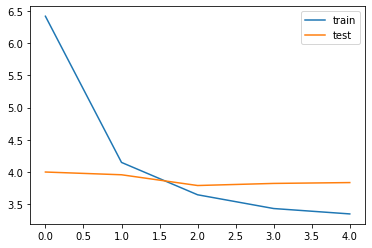

In [75]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [109]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [110]:
def test_encoder(hidden_size, text_max_len, src_vocab, embedding_dim, name='test_encoder'):

    """
    첫번째 문장
    """
    encoder_inputs1 = Input(shape=(text_max_len, ))
    # 인코더의 임베딩 층
    enc_emb1 = Embedding(src_vocab, embedding_dim)(encoder_inputs1)
    # 인코더의 LSTM 1
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb1)

    """
    두번째 문장
    """
    encoder_inputs2 = Input(shape=(text_max_len, ))
    # 인코더의 임베딩 층
    enc_emb2 = Embedding(src_vocab, embedding_dim)(encoder_inputs2)
    # 인코더의 LSTM 2
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(enc_emb2)

    """
    세번째 문장
    """
    encoder_inputs3 = Input(shape=(text_max_len, ))
    # 인코더의 임베딩 층
    enc_emb3 = Embedding(src_vocab, embedding_dim)(encoder_inputs3)
    # 인코더의 LSTM 3
    encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_output3, state_h3, state_c3 = encoder_lstm3(enc_emb3)
    
    
    """
    네번째 문장
    """
    encoder_inputs4 = Input(shape=(text_max_len, ))
    # 인코더의 임베딩 층
    enc_emb4 = Embedding(src_vocab, embedding_dim)(encoder_inputs4)
    # 인코더의 LSTM 3
    encoder_lstm4 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_output4, state_h4, state_c4 = encoder_lstm4(enc_emb4)

    state_h = tf.keras.layers.Average()([state_h1, state_h2, state_h3, state_h4])
    state_c = tf.keras.layers.Average()([state_c1, state_c2, state_c3, state_c4])
    encoder_outputs = tf.keras.layers.Average()([encoder_output1, encoder_output2, encoder_output3, encoder_output4])

    
    return Model([encoder_inputs1, encoder_inputs2, encoder_inputs3, encoder_inputs4], [state_h, state_c, encoder_outputs])

In [111]:
encoder_model = test_encoder(hidden_size, text_max_len, src_vocab, embedding_dim)

In [112]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb2 = dec_emb_layer(decoder_inputs)


# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [107]:
# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [116]:
def decode_sequence(input_seq1, input_seq2, input_seq3, input_seq4):
    # 입력으로부터 인코더의 상태를 얻음
    e_h, e_c, e_out = encoder_model.predict([input_seq1, input_seq2, input_seq3, input_seq4])

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (text_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        #e_h, e_c = h, c

    return decoded_sentence


In [117]:
def seq2text(input_seq1, input_seq2, input_seq3, input_seq4):
    temp1=''
    for i in input_seq1:
        if(i!=0):
            temp1 = temp1 + src_index_to_word[i]+' '
    
    temp2=''
    for i in input_seq2:
        if(i!=0):
            temp2 = temp2 + src_index_to_word[i]+' '
            
    temp3=''
    for i in input_seq3:
        if(i!=0):
            temp3 = temp3 + src_index_to_word[i]+' '
            
    temp4=''
    for i in input_seq4:
        if(i!=0):
            temp4 = temp4 + src_index_to_word[i]+' '
    
    return temp1, temp2, temp3, temp4

In [118]:
for i in range(len(encoder_input_test)):
    print("원문 : ",seq2text(encoder_input_test1[i], encoder_input_test2[i], encoder_input_test3[i], encoder_input_test4[i]))
    print("예측 :",decode_sequence(encoder_input_test1[i].reshape(1, text_max_len), encoder_input_test2[i].reshape(1, text_max_len), encoder_input_test3[i].reshape(1, text_max_len), encoder_input_test4[i].reshape(1, text_max_len)))
    print("\n")


원문 :  ('자 그럼 처음부터 찬찬히 s 거짓말은 하지 않는 편이 좋아 s 우린 벌 써 다 알고 있으니까 ', '이미 으니 한 이야기지만 하도 애원을 하니까 한 번 더 들어 봐 준다는 그런 s 제가 왜 무엇 때문에 합니까 s 정말 s 제가 한 말 은 다 사 s 없읍니다 ', '책상 모서리에 놓인 나무 걸상에 두 무릎을 모으고 단정하게 앉은 새끼 손가락을 하나 세우고 그 새까만 손톱을 가리켜 보이며 울상을 지었다 s 글세 그러니까 한 번 더 얘기해 보라는 거 아냐 s 담배를 붙여 물며 맞은편 벽에 걸린 시계를 쳐다보았다 ', '뻔한 사건을 빨리 끝내 버리고 싶은 그런 눈치였다 s 나 정말 s 정말 ')
예측 :  이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게 이렇게


원문 :  ('당시의 왕은 헨리 s 헨리 헨리 ', '일찍이 것들은 이제 s 사제는 토끼 사냥에 바

KeyboardInterrupt: 

In [ ]:
model.save("novel_model1.h5")

In [ ]:
from keras.models import load_model
from attention import AttentionLayer
model = load_model("novel_model1.h5", custom_objects={'AttentionLayer':AttentionLayer})

In [ ]:
model.summary()